In [1]:
import numpy as np
import plotly.graph_objects as go
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel

import sys
import os
# 使用当前工作目录
project_root = os.path.dirname(os.getcwd())  # 获取当前目录的父目录
sys.path.insert(0, project_root)
from util.methods import assign_variances

seed = 16
# 定义核函数
kernel = ConstantKernel(25.0) * RBF(length_scale=4.0) + WhiteKernel(1e-3)
gp = GaussianProcessRegressor(kernel=kernel)

x_dense = np.linspace(1, 200, 2000).reshape(-1, 1)

y_dense = gp.sample_y(x_dense, n_samples=1, random_state=seed).flatten() + 70

# 提取整数点对应的y值
integer_points = np.arange(1, 201)
y_integers = y_dense[np.linspace(0, 1999, 200, dtype=int)]

# 计算整数点的协方差矩阵
cov_matrix = kernel(integer_points.reshape(-1,1))

# 计算相关性矩阵
std_dev = np.sqrt(np.diag(cov_matrix))  
corr_matrix = cov_matrix / np.outer(std_dev, std_dev)  

np.savetxt('Sigma1.txt', cov_matrix, 
           fmt='%.6f',
           header=f'高斯过程协方差矩阵\n核函数: {kernel}')

np.savetxt('correlation_matrix.txt', corr_matrix,
           fmt='%.6f',
           header=f'高斯过程相关性矩阵\n核函数: {kernel}')

np.savetxt('mu.txt', 
           y_integers,
           fmt='%.6f',
           header='真实均值')

# 创建分组标签 (5组，每组10个点)
group_labels = np.floor(np.argsort(np.argsort(y_integers))/25).astype(int)
group_names = [f"第{i+1}组" for i in range(8)]  # 组别名称

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_dense.flatten(), 
    y=y_dense,
    mode='lines',
    name='GP曲线',
    line=dict(color='royalblue', width=2)
))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#f5fa07', '#07faec', '#f808b9']  # 8种不同颜色
for group in range(8):
    mask = (group_labels == group)
    fig.add_trace(go.Scatter(
        x=integer_points[mask],
        y=y_integers[mask],
        mode='markers',
        name=group_names[group],
        marker=dict(
            color=colors[group],
            size=8,
            line=dict(width=1, color='DarkSlateGrey')
    )))

fig.update_layout(
    title='高斯过程曲线与分组结果',
    xaxis_title='x',
    yaxis_title='f(x)',
    template='plotly_white',
    height=1080,
    width=1920,
    legend=dict(
        title='组别',
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.8)'
    ),
    margin=dict(r=150) 
)

fig.show()

In [2]:
eigvals = np.linalg.eigvals(cov_matrix)
print("最小特征值:", np.min(eigvals))
print("负特征值数量:", np.sum(eigvals < 0))

最小特征值: (0.0009999999999890426+0j)
负特征值数量: 0


验证结果:
对角线均值: 1.000000 (目标: 1.0)
最小特征值: 0.000000+0.000000j (应>0)


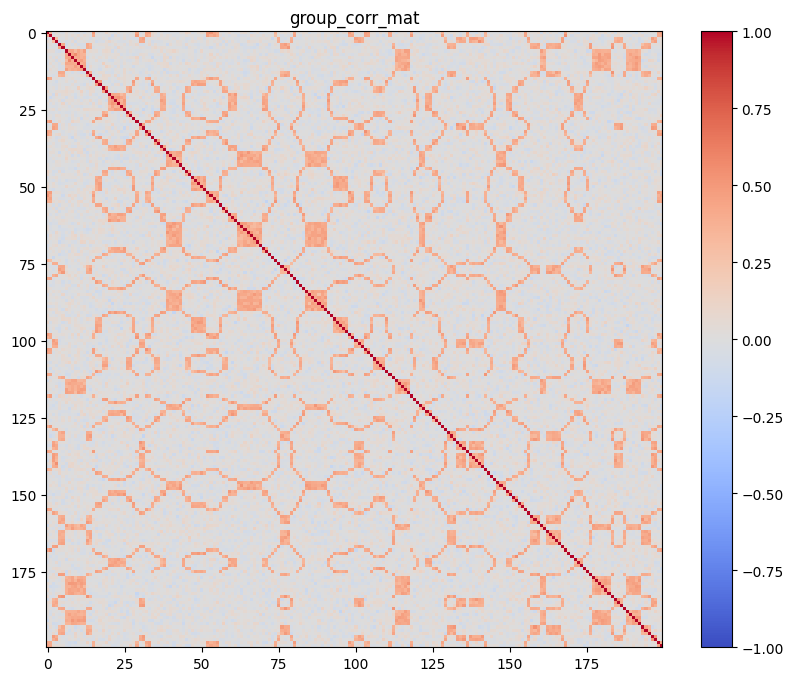

In [3]:
import numpy as np
from scipy.linalg import cholesky
import matplotlib.pyplot as plt

# 初始化参数
n_points = 200
within_group_mean = 0.5
between_group_mean = 0.0
noise_std = 0.1 

np.random.seed(seed=seed)

def build_correlation_matrix(group_labels):
    groups = np.unique(group_labels)
    n_groups = len(groups)
    group_mask = group_labels[:, None] == group_labels  
    
    base_matrix = np.where(group_mask, 
                          within_group_mean, 
                          between_group_mean)
    np.fill_diagonal(base_matrix, 1.0)
    
    random_matrix = np.random.normal(0, noise_std, (n_points, n_points))
    random_matrix = (random_matrix + random_matrix.T) / 2  
    np.fill_diagonal(random_matrix, 0) 
    
    corr_matrix = base_matrix + random_matrix
    

    def project_to_pd(matrix):
        eigvals, eigvecs = np.linalg.eigh(matrix)
        eigvals = np.maximum(eigvals, 1e-8)  
        return eigvecs @ np.diag(eigvals) @ eigvecs.T
    

    for _ in range(10):
        corr_matrix = project_to_pd(corr_matrix)
        # 重新标准化对角线
        diag_scaling = np.diag(1/np.sqrt(np.diag(corr_matrix)))
        corr_matrix = diag_scaling @ corr_matrix @ diag_scaling
    
    return corr_matrix

corr_matrix = build_correlation_matrix(group_labels)

# 验证矩阵性质
print("验证结果:")
print(f"对角线均值: {np.mean(np.diag(corr_matrix)):.6f} (目标: 1.0)")
print(f"最小特征值: {np.min(np.linalg.eigvals(corr_matrix)):.6f} (应>0)")

# 可视化矩阵
plt.figure(figsize=(10,8))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("group_corr_mat")
plt.show()

In [4]:
group_labels+1

array([5, 5, 6, 6, 7, 7, 8, 8, 8, 8, 8, 8, 8, 7, 7, 5, 4, 4, 3, 3, 2, 2,
       2, 2, 2, 2, 3, 3, 4, 5, 6, 6, 5, 5, 4, 3, 3, 2, 2, 1, 1, 1, 1, 1,
       2, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 4, 3, 3, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 3, 4, 5, 6, 7, 7, 7, 6, 5, 4, 3, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 3, 4, 4, 4, 4, 4, 5, 5, 6, 6, 6, 5, 5, 4, 3, 3, 3, 3,
       4, 5, 7, 8, 8, 8, 8, 8, 5, 3, 2, 1, 1, 2, 2, 3, 3, 4, 5, 6, 7, 7,
       7, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 4, 3, 2, 1, 1, 1, 2, 2, 3, 3, 4,
       4, 5, 6, 7, 7, 7, 8, 8, 7, 7, 7, 7, 7, 6, 5, 4, 3, 2, 2, 2, 3, 4,
       7, 8, 8, 8, 8, 8, 8, 7, 6, 6, 6, 7, 8, 8, 8, 8, 8, 7, 7, 7, 6, 6,
       5, 5])

验证结果:
方差范围: 26.37-128.36 (目标: 25-144)
最小特征值: 0.000000 (应>0)


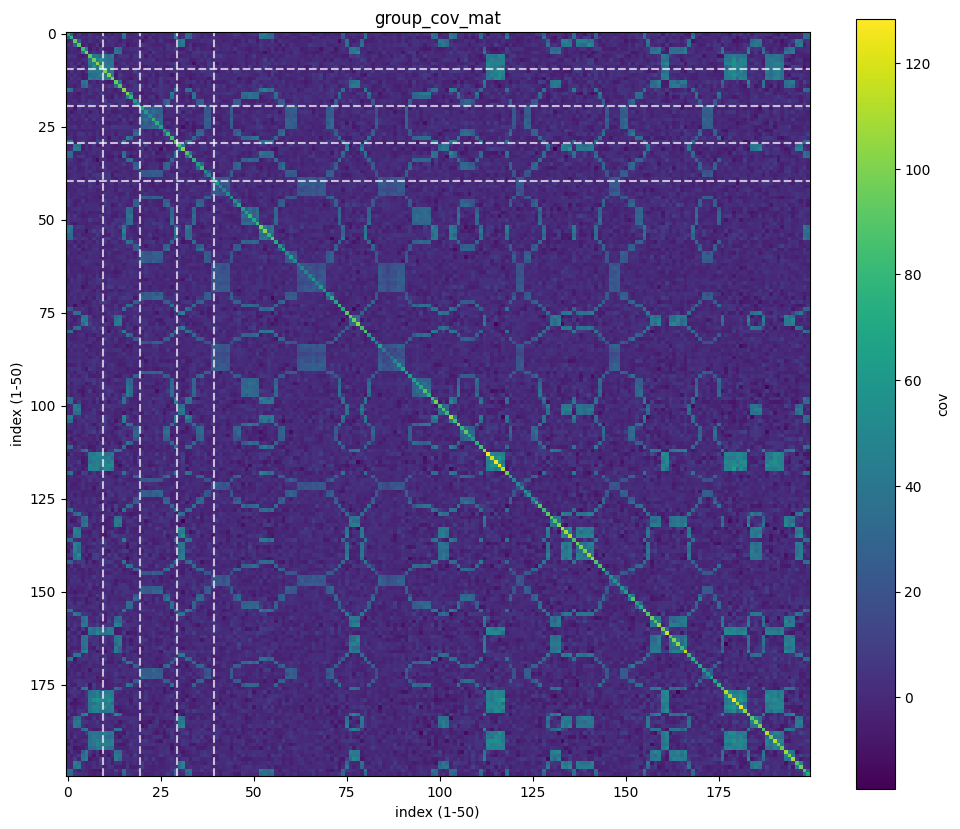

In [5]:
# 随机分配噪声
np.random.seed(seed)  
variances = assign_variances(y_integers, min_var=25, max_var=144, correlation_strength=0.7)
#variances = variances*4
std_devs = np.sqrt(variances)  

D = np.diag(std_devs)

cov_matrix = D @ corr_matrix @ D

print("验证结果:")
print(f"方差范围: {np.min(np.diag(cov_matrix)):.2f}-{np.max(np.diag(cov_matrix)):.2f} (目标: 25-144)")
print(f"最小特征值: {np.min(np.linalg.eigvals(cov_matrix)):.6f} (应>0)")

np.savetxt('group_cov.txt', 
           cov_matrix,
           fmt='%.6f',
           header='协方差矩阵（对角线方差=25-144）\n基于分组相关性矩阵生成')

import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.imshow(cov_matrix, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('cov')

for g in range(1,5):
    plt.axhline(y=g*10-0.5, color='white', linestyle='--', alpha=0.7)
    plt.axvline(x=g*10-0.5, color='white', linestyle='--', alpha=0.7)

plt.title('group_cov_mat')
plt.xlabel('index (1-50)')
plt.ylabel('index (1-50)')
plt.show()


In [6]:
y_integers

array([71.87256263, 72.43090348, 73.00193367, 73.53577716, 74.21969834,
       75.14452189, 76.15057491, 77.06173853, 77.76057248, 78.03321367,
       77.9530202 , 77.3932347 , 76.54572102, 75.46992258, 74.100338  ,
       72.59329112, 71.0059077 , 69.52020051, 68.19161943, 67.05255735,
       66.18028387, 65.44490165, 65.08824422, 64.92131006, 65.26915256,
       66.18794898, 67.63141382, 69.3080002 , 70.94181569, 72.36956889,
       73.16788045, 73.06934559, 72.40857678, 71.20014385, 69.80007311,
       68.59073886, 67.50956326, 66.32733961, 65.10474728, 63.62986658,
       62.4059295 , 61.68336817, 61.81454147, 63.11385858, 64.98905108,
       67.28641093, 68.95776791, 70.09382641, 70.50249468, 70.64765463,
       70.67846823, 71.07673521, 71.79111685, 72.36926997, 72.64103242,
       71.97181309, 70.62440704, 68.83931639, 67.15107764, 65.95829402,
       65.28659222, 64.79654224, 64.28245534, 63.56077894, 62.80710965,
       62.16292127, 61.89584975, 62.35406309, 63.14738933, 64.10

In [7]:
variances

array([ 72.10445424,  77.78767273,  92.97254252,  91.62138145,
        83.82370452,  99.66772626,  91.30174339,  96.84246708,
       104.24514362,  97.28090926,  98.10599556,  99.89290245,
        99.34773279,  93.38489237,  89.65862101, 101.84974548,
       100.34096198,  78.0166895 ,  63.18961729,  59.7713687 ,
        68.70852889,  62.81774871,  47.39596745,  78.41224554,
        74.39617887,  67.20053355,  59.92667806,  78.67398384,
        81.91439286,  92.14073159,  84.56785093, 103.25111137,
        85.88545951,  77.45060121,  76.32807414,  63.51229306,
        78.85839463,  51.02093502,  52.16887952,  50.74317632,
        60.98396143,  53.59459126,  43.71844507,  53.63086673,
        52.82680689,  54.01621036,  69.68064871,  66.0962281 ,
        66.38301651,  79.7083905 ,  69.36346037,  79.07475098,
        97.39022301, 102.80136525,  78.8593246 ,  92.80114486,
        70.60589596,  59.18939757,  68.41600202,  53.58062358,
        67.35676017,  50.87691028,  41.25258825,  46.63